Recurrent Neural Networks (RNN): Simple RNNs and LSTMs
=========

In this tutorial we will learn how to use Recurremt Neural Networks (RNNs) for text processing.
The first example uses a simple RNN to generate the characters in a small text corpus (Alice in Wonderland novel).
We will then look at the Long Short Term Memory (LSTM) networks, for more advanced recurrent models. The LSTM will be tested on a sentiment analysis corpus.


1 - Simple RNNs to Generate text
=========

This exmple will use a simple RNN with one layer of hidden and recurrent units.

Let's first import the usual keras and utility functions. This will include the first importing and use of the SimpleRNN recurrent layer type in Keras.


In [ ]:
from __future__ import print_function
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
import numpy as np


**Loading text file and converting to clean text**

This code will read the file "alice_in_wonderland.txt". This file is available for download here http://www.gutenberg.org/files/11/11-0.txt (and can also be downloaded from Balckboard ).

The code will do some preliminary cleanup of the text (e.g. removing non-ASCII characters and line breaks) and write all words in the variable called "whole_text".


In [3]:
print("Loading text file...")

INPUT_FILE = "alice_in_wonderland.txt"

fin = open(INPUT_FILE, 'rb')
lines = []
for line in fin:
    line = line.strip().lower()
    line = line.decode("ascii", "ignore")
    if len(line) == 0:
        continue
    lines.append(line)
fin.close()
whole_text = " ".join(lines)

print("Done!")


Loading text file...
Done!


**Characters look-up table**

This code will create the look-up table from the 42 characters to integer IDs, and viceversa.

In [4]:
print("Preparing characters look-up table...")

chars = set([c for c in whole_text])
nb_chars = len(chars)
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

print("Done!")

Preparing characters look-up table...
Done!


**Input text and output character**

To create the input text, the code will step through the whole text by a number of characters defined by the __STEP__ variable (1 in our case) and then extract a set of characters whose size is determined by the __SEQLEN__ variable (10 in our case). The next character after the extracted characters is the output label, i,e. the next character to predict.

Here is an example of the input/output for the part of text starting as" it turned into a pig"

   INPUT (10)    ->   OUTPUT (1)
- "it turned "   ->   i
- "t turned i"   ->   n
- " turned in"   ->   t
- "turned int"   ->   o
- "urned into"   ->
- "rned into "   ->   a
- "ned into a"   ->
- "ed into a "   ->   p
- "d into a p"   ->   i
- " into a pi"   ->   g


In [5]:
print("Creating input and label text...")

SEQLEN = 10
STEP = 1

input_chars = []
label_chars = []
for i in range(0, len(whole_text) - SEQLEN, STEP):
    input_chars.append(whole_text[i:i + SEQLEN])
    label_chars.append(whole_text[i + SEQLEN])

print("Done!")

Creating input and label text...
Done!


**Vectorisation of the input and output**

This preprares the input and output vectors of the training set.
The input vector uses one-hot encoding of the __SEQLEN__ (10) characters present in the input text segment, times the __nb_chars__ (42) possible characters.
The output label uses one-hot encoding for the activation of a single character out of the __nb_chars__ number of units/characters.


In [6]:
print("Vectorizing input and label text...")

X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=bool)
y = np.zeros((len(input_chars), nb_chars), dtype=bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1

print("Done!")

Vectorizing input and label text...
Done!


**Simple RNN Model definition**

This codes defines the key variables of the model and training, and creates the sequential model. The model consists of a simple recurrent neural network (RNN) with a hidden layer of 128 simple recurrent units.

The __return_sequences__ is set to __False__ as the output only consists of one character, and not a sequence.
The __unroll=True__ setting improves performance on the TensorFlow backend.
The optimiser uses the __rmsprop__ for backpropagation.



In [7]:
# Definition of the network and training hyperparameters
HIDDEN_SIZE = 128
BATCH_SIZE = 128
NUM_ITERATIONS = 25
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100

# Definition of the network topology, with simpleRNN hidden layer
model = Sequential()
model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=False, input_shape=(SEQLEN, nb_chars), unroll=True))
model.add(Dense(nb_chars))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

#show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               23552     
                                                                 
 dense (Dense)               (None, 55)                7095      
                                                                 
 activation (Activation)     (None, 55)                0         
                                                                 
Total params: 30647 (119.71 KB)
Trainable params: 30647 (119.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training and testing of the model**

The model is trained for __NUM_ITERATIONS__ (25) epochs and tested after each epoch, to allow us to monitor the improvement of the model performance in character prediction.

The test consists of generating a character from the model given a random input, then dropping the first character from the input and appending the predicted character from the previous run as the new input, to generate another character. This is done for __NUM_PREDS_PER_EPOCH__ (100) steps. The completed string gives us an indication of the quality of the model's processing of English words (within the limited lexicon of Alice's novel).


In [8]:
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print("Iteration #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # testing model
    # randomly choose a row from input_chars, then use it to
    # generate text from model for next 100 chars
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]
    print("Generating from seed: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):
        Xtest = np.zeros((1, SEQLEN, nb_chars))
        for i, ch in enumerate(test_chars):
            Xtest[0, i, char2index[ch]] = 1
        pred = model.predict(Xtest, verbose=0)[0]
        ypred = index2char[np.argmax(pred)]
        print(ypred, end="")
        # move forward with test_chars + ypred
        test_chars = test_chars[1:] + ypred
    print()


Iteration #: 0
1237/1237 [==============================] - 7s 4ms/step - loss: 2.3405
Generating from seed: the queen 
the queen and the the the the the the the the the the the the the the the the the the the the the the the the 
Iteration #: 1
1237/1237 [==============================] - 5s 4ms/step - loss: 2.0496
Generating from seed: e that you
e that you case pont in the king to she had cous in the king to she had cous in the king to she had cous in th
Iteration #: 2
1237/1237 [==============================] - 5s 4ms/step - loss: 1.9432
Generating from seed: erything s
erything seat an the was so the wist on the was so the wist on the was so the wist on the was so the wist on t
Iteration #: 3
1237/1237 [==============================] - 5s 4ms/step - loss: 1.8588
Generating from seed: s and shoe
s and shoed to said the coust of the the harded alice the the harded alice the the harded alice the the harded
Iteration #: 4
1237/1237 [==============================] - 6s 5ms/step - lo

This example shows how we can train a Simple RNN to predict the next charaters, using the information from the sequentail relationship between words in the training text.
You can try the same code on a different, longer text, or try different hyperparameters.

We are now ready to try a more complex RNN architecture, for more complex time series tasks.


2 - LSTM for Sentiment Analysis
=========

This example will show how to code the more complex RNN model of the Long Short Term Memmory (LSTM) network. This tutorial will use the example of sentiment analysis prediction.

Let's start with the usual importing of Keras and utility modules. This will of course include the LSTM recurrent layer type.


In [50]:
from tensorflow.keras.layers import Activation, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt') # download instruction required if pubkt nltk package not installed
import numpy as np
import os

print("Initialisation Done! Make sure you have initialised ntlk punkt")

Initialisation Done! Make sure you have initialised ntlk punkt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's now define the main hyperparameter values and text corpus details.


In [51]:
INPUT_FILE = "umich-sentiment-train.txt"

EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10


**Analysis of words in corpus**

This code load the text from the UMICH labelled sentiment analysis corpus file, to identify the number of unique words (length of the __word_freq__ variable, i.e. 2313) and the max number of words in the longest sentence (__maxlen__ expected to be 42). These two variables will be needed later for the preaparation of the training set.


In [52]:
# Read training data and generate vocabulary
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0

ftrain = open(INPUT_FILE)
lines = ftrain.readlines()
i = 0
for line in lines:
    # label, sentence = line.strip().split("\t")
    # print(label, sentence)
    # words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    line = line.strip()
    if len(line) == 0:
      continue
    label, sentence = line[0], line[2:]
    words = nltk.word_tokenize(sentence.lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
    i += 1
ftrain.close()

## Get some information about our corpus
print (maxlen)            # 42
print (len(word_freqs))   # 2313

42
2259


**Unkown word and padding word and lookup tables**

Knowing the number of unique words will permit the identification of the out of vocabulary (OOV) words, which can be replaced by the pseudo-word "UNK" (for unknown). When testing the network prediction, this will allow us to handle previously unseen OOV words.

We can decide a fixed sequence length by truncating longer sentences to that length as appropriate (__MAX_SENTENCE_LENGTH = 40__). We also use the PAD to make shorter sentence equivalent to the fixed max length.

Overall, we set our VOCABULARY_SIZE to 2002. i.e. 2,000 words from our vocabulary plus the UNK pseudo-word and the PAD pseudo word used for padding sentences up to the max length.

We then create the look-up tables. Each row of input to the network is a sequence of word indices, where the indices are ordered by most frequent to least frequent word in the training set.

In [53]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

# 1 is UNK, 0 is PAD
# We take MAX_FEATURES-1 featurs to accound for PAD
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in
                enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}


**Prepare training sequences**

The input sentences need to be converted to  word index sequences (inlcuding their padiing to the max sequecne length).
No procesing required for the output, as this is a positive/negative binary sentiment output.


In [54]:
# convert sentences to sequences
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
ftrain = open(INPUT_FILE)
lines = ftrain.readlines()
for line in lines:
    # label, sentence = line.strip().split(b"\t")
    # words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    line = line.strip()
    if len(line) == 0:
      continue
    label, sentence = line[0], line[2:]
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()

# Pad the sequences (left padded with zeros)
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

# Split input into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(5581, 40) (1396, 40) (5581,) (1396,)


**Model building and compilation**

The codes defines the LSTM model topology, as per figure below. This is a stdnard recurrent network with one layer of LSTM units.

![image.png](attachment:image.png)


In [55]:
# Build model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#show the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           256256    
                                                                 
 spatial_dropout1d (Spatial  (None, 40, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 305729 (1.17 MB)
Trainable params: 305729 (1.17 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

**Training of the model**

Let's train our LSTM RNN.
The model uses the binary cross-entropy loss function, suitable for binary value prediction. The Adam optimizer is one of the best and most frequently used general purpose optimizers.


In [58]:
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, ytest))

Epoch 1/10
175/175 [==============================] - 39s 184ms/step - loss: 0.2267 - accuracy: 0.9006 - val_loss: 0.0597 - val_accuracy: 0.9792
Epoch 2/10
175/175 [==============================] - 24s 136ms/step - loss: 0.0244 - accuracy: 0.9932 - val_loss: 0.0370 - val_accuracy: 0.9893
Epoch 3/10
175/175 [==============================] - 24s 135ms/step - loss: 0.0089 - accuracy: 0.9986 - val_loss: 0.0369 - val_accuracy: 0.9864
Epoch 4/10
175/175 [==============================] - 24s 136ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0436 - val_accuracy: 0.9850
Epoch 5/10
175/175 [==============================] - 25s 140ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0419 - val_accuracy: 0.9885
Epoch 6/10
175/175 [==============================] - 24s 135ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0389 - val_accuracy: 0.9900
Epoch 7/10
175/175 [==============================] - 23s 134ms/step - loss: 6.8051e-04 - accuracy: 0.9998 - val_loss: 0.0378 - va

**Plotting of the results**

The code below will produce accuracy and loss plots for training and validation data.


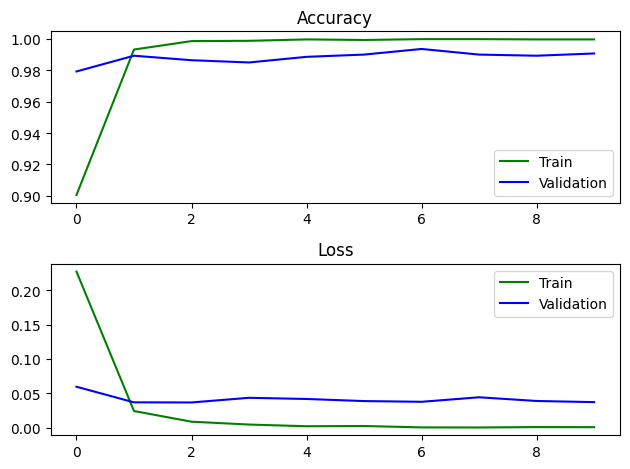

In [59]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="g", label="Train")
plt.plot(history.history["val_accuracy"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


**Evaluation of the model**

The model is evaluated against the full test set, printing the score and accuracy.
The code also generates a few random sentences from the test set and prints the model's prediction, the label and the actual sentence. This will give us an idea of the quality of the prediction.


In [60]:
# evaluate
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))


44/44 [==============================] - 1s 14ms/step - loss: 0.0373 - accuracy: 0.9907
Test score: 0.037, accuracy: 0.991
1/1 [==============================] - 0s 248ms/step
1	1	he 's like , 'yeah i got acne and i love brokeback mountain ' ..
1/1 [==============================] - 0s 28ms/step
0	0	as i sit here , watching the mtv movie awards , i am reminded of how much i despised the movie brokeback mountain .
1/1 [==============================] - 0s 26ms/step
0	0	harry potter dragged draco malfoy ’ s trousers down past his hips and sucked him into his throat with vigor , making whimpering noises and panting and groaning around the blonds rock-hard , aching cock ...
1/1 [==============================] - 0s 29ms/step
1	1	i went to little vic 's bday party and saw mission impossible 3 which was just so awesome .
1/1 [==============================] - 0s 30ms/step
0	0	i did UNK once , UNK a new UNK , and left two stupid / short UNK on the brokeback mountain board .


Conclusions
-------------

This exercise finishes our short deep leanring course. You know have a pracyicla understanding of how to train a simple MLP (multi-Layer Perceptron), CNNs (Concolutional Neural Networks) with different layers, a simple RNN (Recurrent Neural network) and the more complex LSTM (Long Short Term Neural Network). Well done!

**Copyright (c)** 2022 Angelo Cangelosi, MIT License. Code and examples adapted from Gulli & Pal (2017) Deep Learning with Keras. Punkt Publishing. With the support of Wenjie Huang.